Detecting melanoma, a potentially lethal form of skin cancer responsible for 75% of skin cancer deaths, is of paramount importance for early intervention and improved patient outcomes. Developing an effective solution to accurately identify melanoma through image analysis not only holds the promise of saving lives but also has the potential to alleviate the substantial manual effort required in the diagnostic process. In pursuit of this objective, we have created a sophisticated convolutional Neural Network (CNN) based model that leverages the power of deep learning to analyze skin images. Additionally, we have explored advanced data augmentation strategies to enhance the model's robustness and generalization capabilities. This technology, combining the strength of CNN architecture and innovative data augmentation techniques, emerges as a critical tool for providing dermatologists with a reliable means of evaluating skin images and promptly alerting them to the presence of melanoma. Such an integrated approach can significantly enhance the efficiency and precision of melanoma detection, thereby contributing to the advancement of early diagnosis and intervention strategies.

### Importing Skin Cancer Data

Let's import important libraries and the data necessary for our tasks

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Loading using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Let's define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In this section we will create our training set and validation set. 80% of the images will be used for training, and 20% for validation.

In [5]:
# Creating a training dataset using images from the specified directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                    # Directory path for the training images
  validation_split=0.2,               # Splitting the data into training and validation sets (80% training, 20% validation)
  subset="training",                  # Using the subset for training
  seed=123,                           # Seed for reproducibility
  image_size=(img_height, img_width),  # Size to which the images will be resized
  batch_size=batch_size               # Batch size for training
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# Creating a validation dataset using images from the specified directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                    # Directory path for the training images
  validation_split=0.2,               # Splitting the data into training and validation sets (80% training, 20% validation)
  subset="validation",                # Using the subset for validation
  seed=123,                           # Seed for reproducibility
  image_size=(img_height, img_width),  # Size to which the images will be resized
  batch_size=batch_size               # Batch size for validation
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# Let's list out all the classes of skin cancer and store them in a list. 
# We can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

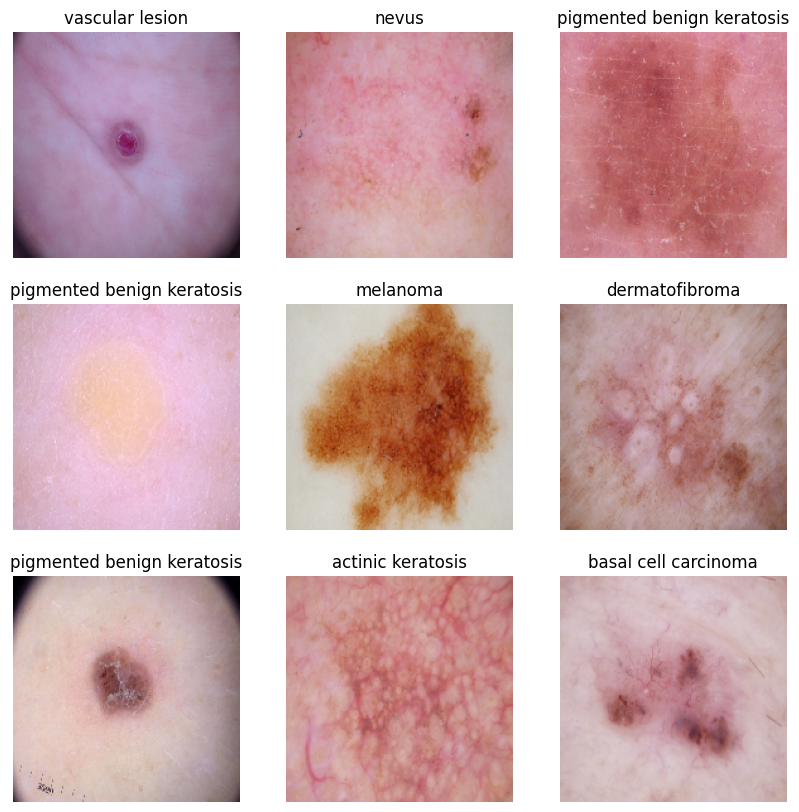

In [8]:
# Importing the necessary libraries
import matplotlib.pyplot as plt

# Setting the size of the figure
plt.figure(figsize=(10, 10))

# Taking the first batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
  
  # Iterating through the first 9 images in the batch
  for i in range(9):
    
    # Creating subplots in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # Displaying the image (converting to uint8 format)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    # Adding the class name (assuming class_names is defined elsewhere in the code)
    plt.title(class_names[labels[i]])
    
    # Removing axis labels for better visualization
    plt.axis("off")

# Displaying the plot
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### In this section, we create a CNN model, which can accurately detect 9 classes present in the dataset. We use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
# Number of classes in the classification problem
num_classes = len(class_names)

# Defining the CNN model architecture
model = Sequential([
    # Rescale the pixel values to the range [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    # Max pooling layer to downsample the spatial dimensions
    layers.MaxPooling2D(),
    
    # Second convolutional layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Third convolutional layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Flatten layer to convert the 3D feature maps to 1D
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    
    # Output layer with 'num_classes' neurons (for classification)
    layers.Dense(num_classes)
])


### Compiling the model
Here we choose an appropriate optimiser and loss function for model training 

In [11]:
# Compiling the model with specified optimizer, loss function, and evaluation metrics
model.compile(
    optimizer='adam',  # Using the Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse categorical crossentropy loss
    metrics=['accuracy']  # Monitoring accuracy as the evaluation metric
)

In [12]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [13]:
# Number of training epochs
epochs = 20

# Training the model with the specified number of epochs using the training dataset
# and validating on the validation dataset
history = model.fit(
    train_ds,                  # Training dataset
    validation_data=val_ds,    # Validation dataset
    epochs=epochs              # Number of training epochs
)

Epoch 1/20


56/56 [==============================] - 36s 383ms/step - loss: 2.2388 - accuracy: 0.2104 - val_loss: 1.9719 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 17s 311ms/step - loss: 1.8992 - accuracy: 0.2896 - val_loss: 1.9154 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 22s 389ms/step - loss: 1.7025 - accuracy: 0.3884 - val_loss: 1.6004 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 19s 346ms/step - loss: 1.5612 - accuracy: 0.4392 - val_loss: 1.7737 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 19s 331ms/step - loss: 1.4053 - accuracy: 0.5095 - val_loss: 1.8301 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 19s 335ms/step - loss: 1.3288 - accuracy: 0.5424 - val_loss: 1.3953 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 19s 337ms/step - loss: 1.2612 - accuracy: 0.5569 - val_loss: 1.4207 - val_accuracy: 0.5011
Epoch 8/20

### Visualizing training results

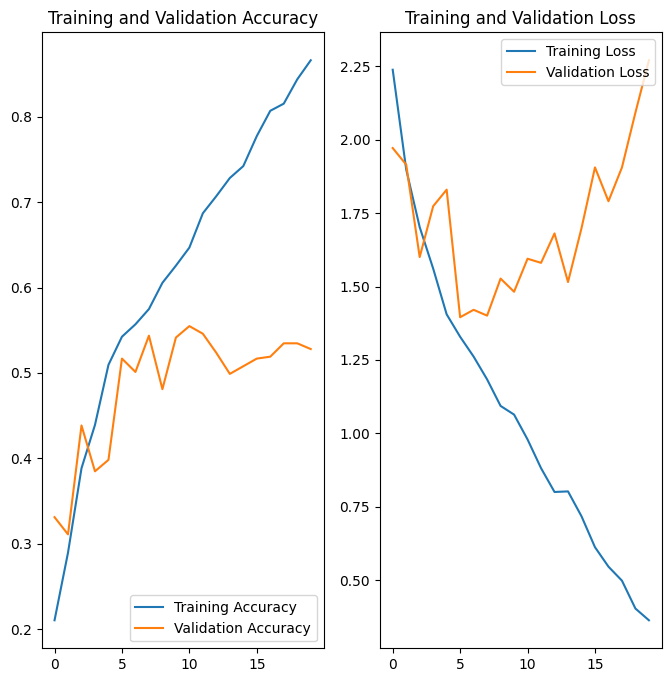

In [14]:
# Extracting accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating a range of epochs for plotting
epochs_range = range(epochs)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Displaying the plots
plt.show()

#### Inference

- The training accuracy has a general upward trend, with it reaching a maximum of an accuracy slightly more than 86%, whereas the validation accuracy does not improve significantly beyond 65%
- The training loss has a general downward trend, and the validation loss, although following a downward trend till 5 epochs, follows an upward trend after 5 epochs.

These are clear signs of overfitting.

### Data Augmentation

The model might be overfitting due to less data. To try and rectify that, we will augment the data by taking the images and randomly rotating and flipping it to create new images for each classes.

In [15]:
# Defining a data augmentation Sequential model
data_augmentation = Sequential(
    [
        # Randomly flip input images horizontally
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        
        # Randomly rotate input images by a factor within the specified range
        layers.RandomRotation(0.1),
        
        # Randomly zoom into input images by a factor within the specified range
        layers.RandomZoom(0.1),
    ]
)

Visualizing how the augmentation strategy works for one instance of training image.

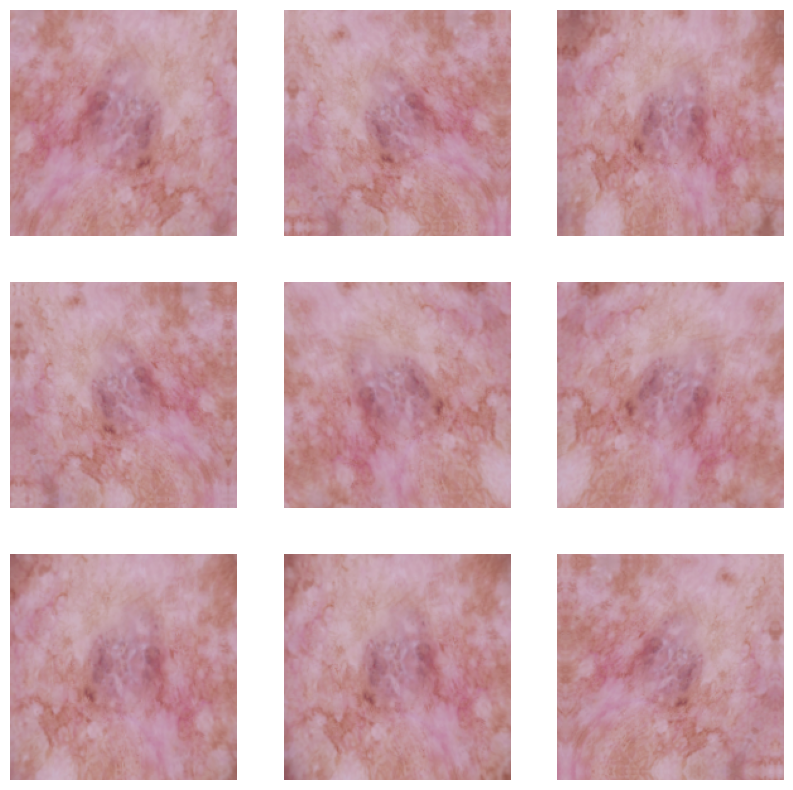

In [16]:

# Setting up a Matplotlib figure for displaying augmented images
plt.figure(figsize=(10, 10))

# Taking the first batch of images from the training dataset
for images, _ in train_ds.take(1):
  
  # Applying data augmentation to the batch of images
  for i in range(9):
    augmented_images = data_augmentation(images)
    
    # Creating subplots in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # Displaying the augmented image (converting to uint8 format)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    
    # Removing axis labels for better visualization
    plt.axis("off")

# Displaying the plot with augmented images
plt.show()


### Creating the model, compiling and training the model

With our augmenting strategy in place, let's build, compile and train the model 

In [17]:
## We will use Dropout layer as there is an evidence of overfitting in your findings

# Defining the model architecture with data augmentation
model = Sequential([
    # Data augmentation layer
    data_augmentation,
    
    # Rescaling layer to normalize pixel values to the range [0, 1]
    layers.Rescaling(1./255),
    
    # First convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    # Max pooling layer to downsample the spatial dimensions
    layers.MaxPooling2D(),
    
    # Second convolutional layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Third convolutional layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Dropout layer with a dropout rate of 20% to prevent overfitting
    layers.Dropout(0.2),
    
    # Flatten layer to convert the 3D feature maps to 1D
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    
    # Output layer with 'num_classes' neurons and a name for easier access in the future
    layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [18]:
# Compiling the model with specified optimizer, loss function, and evaluation metrics
model.compile(
    optimizer='adam',  # Using the Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse categorical crossentropy loss
    metrics=['accuracy']  # Monitoring accuracy as the evaluation metric
)

### Training the model

In [19]:
# Number of training epochs
epochs = 20

# Training the model with the specified number of epochs using the training dataset
# and validating on the validation dataset
history = model.fit(
    train_ds,                  # Training dataset
    validation_data=val_ds,    # Validation dataset
    epochs=epochs              # Number of training epochs
)

Epoch 1/20


56/56 [==============================] - 21s 360ms/step - loss: 2.0925 - accuracy: 0.2054 - val_loss: 1.9947 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 20s 365ms/step - loss: 1.8123 - accuracy: 0.3438 - val_loss: 1.6429 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 21s 381ms/step - loss: 1.6106 - accuracy: 0.4353 - val_loss: 1.5289 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 22s 385ms/step - loss: 1.5224 - accuracy: 0.4799 - val_loss: 1.5366 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 21s 368ms/step - loss: 1.5069 - accuracy: 0.4660 - val_loss: 1.4206 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 20s 360ms/step - loss: 1.4020 - accuracy: 0.5140 - val_loss: 1.4001 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 20s 361ms/step - loss: 1.3335 - accuracy: 0.5413 - val_loss: 1.3928 - val_accuracy: 0.5280
Epoch 8/20

### Visualizing the results

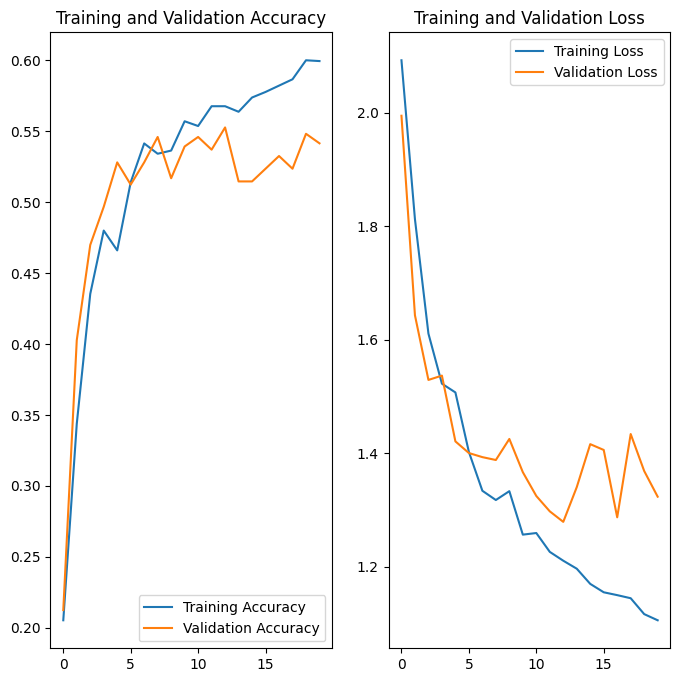

In [ ]:
# Extracting accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating a range of epochs for plotting
epochs_range = range(epochs)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Displaying the plots
plt.show()

#### Inference

- The training and validation accuracy both follow a similar upward trend for about 5 epochs, after which the validation accuracy stops improving beyond 55% but the training accuracy improves and reaches about 60%.
- The training and validation loss follow a similar trend for about 5 epochs, after which the validation fluctuates but does not significantly improve beyond a certain range, while the training loss keeps improving.
- Compared to the previous case, the difference between the training and validation accuracy along with the training and validation loss is lower.

We can conclude that the data augmentation strategy significantly improved the overfitting problem, but did not solve it completely.  

 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
## Your code goes here.
from keras.preprocessing.image import ImageDataGenerator

# Define your ImageDataGenerator with the desired preprocessing parameters
datagen = ImageDataGenerator(rescale=1./255, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True)

# Specify the path to your dataset
dataset_path = 'D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train'

# Use flow_from_directory to generate batches of data
batch_size = 32
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical'  # specify class mode as 'categorical' for one-hot encoded labels
)

# Get the class indices and class labels
class_indices = generator.class_indices
class_labels = list(class_indices.keys())

# Get the number of images in each class
class_distribution = {}
for class_label in class_labels:
    class_distribution[class_label] = len(generator.labels[generator.labels == class_indices[class_label]])

# Print the class distribution
print("Class Distribution:")
for class_label, count in class_distribution.items():
    print(f"{class_label}: {count} images")


Found 2239 images belonging to 9 classes.
Class Distribution:
actinic keratosis: 114 images
basal cell carcinoma: 376 images
dermatofibroma: 95 images
melanoma: 438 images
nevus: 357 images
pigmented benign keratosis: 462 images
seborrheic keratosis: 77 images
squamous cell carcinoma: 181 images
vascular lesion: 139 images


#### Inference

- The class `seborrheic keratosis` has the least number of instances, with 77 instances.
- The class `melanoma` dominates the other classes based on the number of instances, which are 462.

There is class imbalance in the dataset, which is a problem to efficient model building.

#### =Rectifying the class imbalance
Let's use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
path_to_training_dataset = r"D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
import Augmentor

for class_name in class_names:
    current_class_path = os.path.join(path_to_training_dataset, class_name)
    
    # Check if the directory exists
    if not os.path.exists(current_class_path):
        print(f"Error: The directory {current_class_path} does not exist.")
        continue

    p = Augmentor.Pipeline(current_class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21AB51C7390>: 100%|██████████| 500/500 [00:02<00:00, 170.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AB5206190>: 100%|██████████| 500/500 [00:02<00:00, 195.38 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AB51EB610>: 100%|██████████| 500/500 [00:02<00:00, 191.28 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21AB640AE10>: 100%|██████████| 500/500 [00:12<00:00, 39.30 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x21AB62E4310>: 100%|██████████| 500/500 [00:11<00:00, 43.92 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21ABC9E0810>: 100%|██████████| 500/500 [00:02<00:00, 171.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21AB51FF450>: 100%|██████████| 500/500 [00:06<00:00, 75.55 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21AB63EDC10>: 100%|██████████| 500/500 [00:03<00:00, 166.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AB642E690>: 100%|██████████| 500/500 [00:02<00:00, 169.77 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['D:\\Pratik\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_34bb507d-b77d-48ea-aadf-5721f8ed84c4.jpg',
 'D:\\Pratik\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_389e14be-5cf1-4a7e-8776-68d36ad671e6.jpg',
 'D:\\Pratik\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3c39a259-0ec7-4abb-b854-000bac600c8f.jpg',
 'D:\\Pratik\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_66819371-84bd-4753-8e2b-04c49a87ca1b.jpg',
 'D:\\Pratik\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

Let's check how many instances were added by the Augmentor library.

In [26]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [28]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Let's train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [32]:
data_dir_train=r"D:\Pratik\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model

In [34]:
# Defining the model architecture without data augmentation
model = Sequential([
    # Rescaling layer to normalize pixel values to the range [0, 1]
    layers.Rescaling(1./255),
    
    # First convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    # Max pooling layer to downsample the spatial dimensions
    layers.MaxPooling2D(),
    
    # Second convolutional layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Third convolutional layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    # Another max pooling layer
    layers.MaxPooling2D(),
    
    # Dropout layer with a dropout rate of 20% to prevent overfitting
    layers.Dropout(0.2),
    
    # Flatten layer to convert the 3D feature maps to 1D
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    
    # Output layer with 'num_classes' neurons and a name for easier access in the future
    layers.Dense(num_classes, name="outputs")
])


#### Compiling the model

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [36]:
epochs = 50
## Using 50 epochs as instructed by starter code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 65s 378ms/step - loss: 1.8863 - accuracy: 0.2830 - val_loss: 1.4297 - val_accuracy: 0.4803
Epoch 2/50
169/169 [==============================] - 63s 370ms/step - loss: 1.4217 - accuracy: 0.4661 - val_loss: 1.3831 - val_accuracy: 0.4788
Epoch 3/50
169/169 [==============================] - 63s 372ms/step - loss: 1.1978 - accuracy: 0.5564 - val_loss: 1.1247 - val_accuracy: 0.5857
Epoch 4/50
169/169 [==============================] - 63s 373ms/step - loss: 0.9707 - accuracy: 0.6471 - val_loss: 1.1282 - val_accuracy: 0.5687
Epoch 5/50
169/169 [==============================] - 63s 371ms/step - loss: 0.8452 - accuracy: 0.6992 - val_loss: 1.0426 - val_accuracy: 0.6347
Epoch 6/50
169/169 [==============================] - 63s 371ms/step - loss: 0.6486 - accuracy: 0.7721 - val_loss: 0.8369 - val_accuracy: 0.7045
Epoch 7/50
169/169 [==============================] - 62s 364ms/step - loss: 0.5443 - accuracy: 0.8095 - val_loss: 1.0310 - val_ac

#### **Todo:**  Visualize the model results

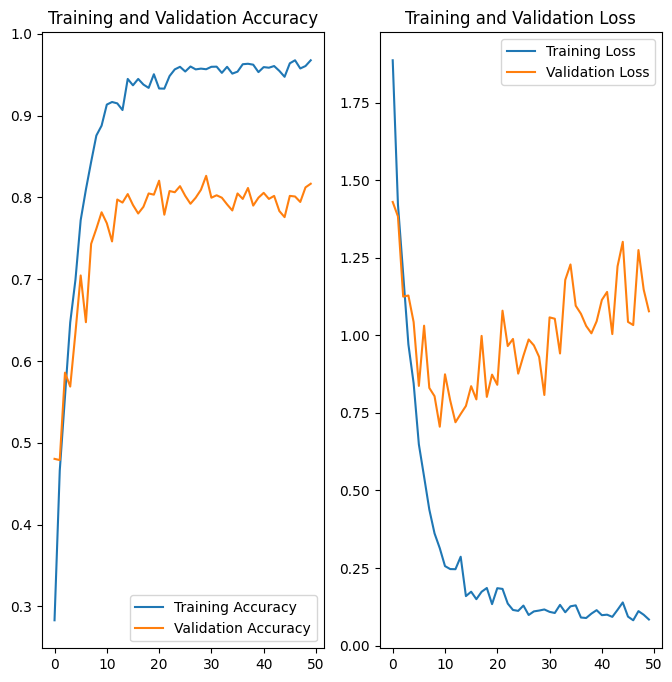

In [37]:
# Extracting accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating a range of epochs for plotting
epochs_range = range(epochs)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Displaying the plots
plt.show()


#### Inference

- The training and validation accuracy have been significantly boosted.
- The training and validation accuracy follow a similar trend, with them steadily increasing till around 10 epochs and then not showing any significant improvement.
- The training loss improves till about 10 epochs, and then there is no significant improving. 
- The validation loss improves till 10 epochs, and then starts increasing and follows a general increasing trend with great fluctuations.

Hence, the problem of overfitting was not solved, but the accuracy was significantly boosted.

It is likely that the problem lies in the architecture. Rebuilding the model with different hyperparameters and reconfiguring the layers seems like the next step to solving the overfitting problem. 